# Trabajo Práctico Nº2

**Integrantes**:
- Carolina Perez Omodeo
- Emiliano Uriel Martino
- Alan Perez Winter

**Objetivos**:
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: *focus_video.mov*.
1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper *Image Sharpness Measure for Blurred Images in Frequency Domain* y realizar tres experimentos:
    1. Medición sobre todo el frame.
    2. Medición sobre una ROI ubicada en el centro del frame.  Area de la ROI = 5 o 10% del area total del frame.
    3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc ... (al menos 3).
    
    Para cada experimento se debe presentar:
    - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
    - Video con la ROI o matriz,  graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames donde se detecta la condición de máximo enfoque.
2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

**Puntos extra**: Aplicar unsharp masking para expandir la zona de enfoque y devolver.


In [39]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

### Clase Video

In [40]:
class Video(object):

    @staticmethod
    def getRoi(frame, percentage:float=1.0):
        h, w = frame.shape[:2]
        roi_h, roi_w = int(h * percentage), int(w * percentage)
        start_h, start_w = (h - roi_h) // 2, (w - roi_w) // 2
        return frame[start_h:start_h + roi_h, start_w:start_w + roi_w]
    
    @staticmethod
    def drawRoi(frame, percentage:float=0.5, in_focus: bool=False):
        h, w = frame.shape[:2]
        roi_h, roi_w = int(h * percentage), int(w * percentage)
        start_h, start_w = (h - roi_h) // 2, (w - roi_w) // 2
        color = (0, 255, 0) if in_focus else (0, 0, 255)
        font = cv.FONT_HERSHEY_SIMPLEX
        label = f'ROI {percentage * 100:.2g}%'
        cv.rectangle(frame, (start_w, start_h), (start_w + roi_w, start_h + roi_h), color, 2)
        cv.putText(frame, label, (10, 30), font, 1, (255, 255, 255), 2, cv.LINE_AA)
        return frame
    
    @staticmethod
    def getMatrixOfRegions(frame, N:int=3, M:int=3, height:int=30, 
                           width:int=30, dy:int=30, dx:int=30):
        regions = []
        frame_h = frame.shape[0]
        frame_w = frame.shape[1]
        matrix_h = N * height + (N - 1) * dy
        matrix_w = M * width + (M - 1) * dx
        margin_x = (frame_w - matrix_w) // 2
        margin_y = (frame_h - matrix_h) // 2

        for i in range(N):
            for j in range(M):
                x = margin_x + j * (width + dx)
                y = margin_y + i * (height + dy)
                regions.append(frame[y:y + height, x:x + width])
                
        return regions
    
    @staticmethod
    def drawMatrixOfRegions(frame, N:int=3, M:int=3, height:int=30, 
                            width:int=30, dy:int=30, dx:int=30, in_focus:bool=False):
        frame_cp = frame.copy()
        frame_h = frame_cp.shape[0]
        frame_w = frame_cp.shape[1]
        matrix_h = N * height + (N - 1) * dy
        matrix_w = M * width + (M - 1) * dx
        margin_x = (frame_w - matrix_w) // 2
        margin_y = (frame_h - matrix_h) // 2

        for i in range(N):
            for j in range(M):
                x = margin_x + j * (width + dx)
                y = margin_y + i * (height + dy)
                color = (0, 255, 0) if in_focus else (0, 0, 255)
                cv.rectangle(frame_cp, (x, y), (x + width, y + height), color, 2)
        
        return frame_cp
    
    @staticmethod
    def unsharp_mask(frame, sigma=1.0, alpha=1.5, beta=-0.5):
        blurred = cv.GaussianBlur(frame, (0, 0), sigma)
        unsharp_mask = cv.addWeighted(frame, alpha, blurred, beta, 0)
        return unsharp_mask
    
    @staticmethod
    def create_video_from_frames(frames, output_file:str, fps:int=30):
        h, w = frames[0].shape[:2]
        fourcc = cv.VideoWriter_fourcc(*'mp4v')
        out = cv.VideoWriter(output_file, fourcc, fps, (w, h))
        for frame in frames:
            out.write(frame)
        out.release()
    
    def __init__(self, path):
        self.path = path
        self.video = cv.VideoCapture(path)
        self.fps = self.video.get(cv.CAP_PROP_FPS)
        self.width = int(self.video.get(cv.CAP_PROP_FRAME_WIDTH))
        self.height = int(self.video.get(cv.CAP_PROP_FRAME_HEIGHT))
        self.n_frames = int(self.video.get(cv.CAP_PROP_FRAME_COUNT))

    def getFrame(self, index:int):
        self.video.set(cv.CAP_PROP_POS_FRAMES, index)
        ret, frame = self.video.read()
        return frame if ret else None
    
    def getFrames(self, indices:list):
        frames = []
        for i in indices:
            self.video.set(cv.CAP_PROP_POS_FRAMES, i)
            ret, frame = self.video.read()
            if not ret:
                break
            frames.append(frame)
        return frames
    
    def getFrameIndicesBySharpnessRange(self, min_sharpness:float, max_sharpness:float):
        sharpness = self.computeSharpnessMetric()
        indices = [i for i, s in enumerate(sharpness) if min_sharpness <= s <= max_sharpness]
        return indices
    
    def computeSharpnessMetric(self, frames:list=None, percentage:float=1.0, unsharp_mask:bool=False):
        metrics = []
        if frames is None:
            frames = self.getFrames(range(self.n_frames))
        for frame in frames:
            frame = self.getRoi(frame, percentage)
            gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
            gray = Video.unsharp_mask(gray) if unsharp_mask else gray
            fft = np.fft.fftshift(np.fft.fft2(gray))
            af = np.abs(fft)
            max_af = np.max(af)
            th = np.sum(np.where(af >= max_af/1000))
            metrics.append(th / (frame.shape[0] * frame.shape[1]))
        return metrics
    
    def computeLaplacianSharpnessMetric(self, frames:list=None, percentage:float=1.0, unsharp_mask:bool=False):
        """Compute the energy of the Laplacian of the image as a measure of sharpness.

        Args:
            frames (list, optional): Frames as a numpy array 2D matrix. Defaults to None.
            percentage (float, optional): Defines the region of interest. Defaults to 1.0.

        Returns:
            list: List of Laplacian sharpness metrics for each frame.
        """
        metrics = []
        if frames is None:
            frames = self.getFrames(range(self.n_frames))
        for frame in frames:
            frame = self.getRoi(frame, percentage)
            gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
            gray = Video.unsharp_mask(gray) if unsharp_mask else gray
            laplacian = cv.Laplacian(gray, cv.CV_64F)
            metrics.append(np.sum((laplacian**2).flatten()))
        return metrics
    
    def computeSharpnessMetricByMOR(self, frames:list=None, N:int=3, M:int=3, height:int=30, 
                                    width:int=30, dy:int=30, dx:int=30, method:str="fft", unsharp_mask:bool=False):
        metrics = []
        if frames is None:
            frames = self.getFrames(range(self.n_frames))
        for frame in frames:
            regions = self.getMatrixOfRegions(frame, N, M, height, width, dy, dx)
            if method == "fft":
                sharpness = self.computeSharpnessMetric(regions, unsharp_mask=unsharp_mask)
            else:
                sharpness = self.computeLaplacianSharpnessMetric(regions, unsharp_mask=unsharp_mask)
            metrics.append(np.mean(np.array(sharpness)))
        return metrics
    
    def getFocusFrameByMOR(self, frames:list=None, N:int=3, M:int=3, height:int=30, 
                           width:int=30, dy:int=30, dx:int=30, method:str="fft", unsharp_mask:bool=False):
        metrics = []
        if frames is None:
            frames = self.getFrames(range(self.n_frames))
        for frame in frames:
            regions = self.getMatrixOfRegions(frame, N, M, height, width, dy, dx)
            if method == "fft":
                sharpness = self.computeSharpnessMetric(regions, unsharp_mask=unsharp_mask)
                metrics.append(np.mean(np.array(sharpness)))
            else:
                sharpness = self.computeLaplacianSharpnessMetric(regions, unsharp_mask=unsharp_mask)
                metrics.append(np.mean(np.array(sharpness)))
        focus_data = (np.argmax(metrics), np.max(metrics), frames[np.argmax(metrics)])
        return focus_data
    
    def getFocusFrameByROI(self, frames:list=None, percentage:float=1.0, method:str="fft", unsharp_mask:bool=False):
        if frames is None:
            frames = self.getFrames(range(self.n_frames))
        if method == "fft":
            sharpness = self.computeSharpnessMetric(frames, percentage=percentage, unsharp_mask=unsharp_mask)
        else:
            sharpness = self.computeLaplacianSharpnessMetric(frames, percentage=percentage, unsharp_mask=unsharp_mask)
        focus_data = (np.argmax(sharpness), np.max(sharpness), frames[np.argmax(sharpness)])
        return focus_data
    
    def getRoiFromFrames(self, indices:list=None, percentage:float=0.5):
        frames = []
        if indices is None:
            indices = range(self.n_frames)
        for i in indices:
            self.video.set(cv.CAP_PROP_POS_FRAMES, i)
            ret, frame = self.video.read()
            if not ret:
                break
            frames.append(self.getRoi(frame, percentage))
        return frames
    
    def drawFramesWithRoi(self, indices:list=None, percentage:float=0.5, in_focus:list=None):
        frames = []
        if indices is None:
            indices = range(self.n_frames)
        if in_focus is None:
            in_focus = [False] * len(indices)
        for i in indices:
            self.video.set(cv.CAP_PROP_POS_FRAMES, i)
            ret, frame = self.video.read()
            if not ret:
                break
            frames.append(self.drawRoi(frame, percentage, in_focus[i]))
        return frames

### Detección sobre el cuadro completo

In [41]:
my_video = Video("focus_video.mov")

# Metric: FFT. No unsharp mask
sharpness_fft = my_video.computeSharpnessMetric()
frame_i_fft, frame_shp_fft, focus_frame_fft = my_video.getFocusFrameByROI()

# Metric: Laplacian. No unsharp mask
sharpness_lap = my_video.computeLaplacianSharpnessMetric()
frame_i_lap, frame_shp_lap, focus_frame_lap = my_video.getFocusFrameByROI(method="laplacian")

frames = my_video.getFrames(range(my_video.n_frames))
frames_um = [Video.unsharp_mask(frame.copy()) for frame in frames]

# Metric: FFT. Unsharp mask
sharpness_fft_um = my_video.computeSharpnessMetric(frames_um)
frame_i_fft_um, frame_shp_fft_um, focus_frame_fft_um = my_video.getFocusFrameByROI(unsharp_mask=True)

# Metric: Laplacian. Unsharp mask
sharpness_lap_um = my_video.computeLaplacianSharpnessMetric(frames_um)
frame_i_lap_um, frame_shp_lap_um, focus_frame_lap_um = my_video.getFocusFrameByROI(method="laplacian", unsharp_mask=True)

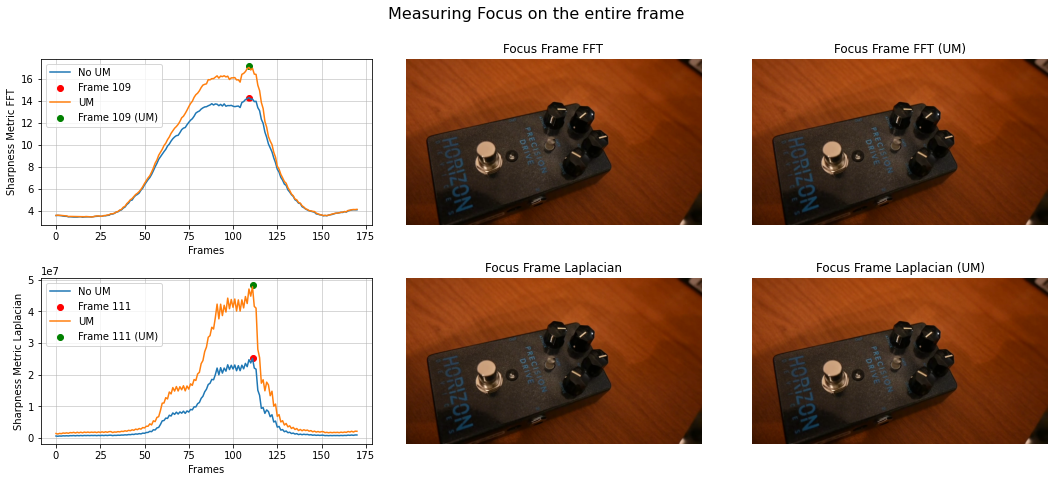

In [42]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))

# Plotting FFT metric
axs[0, 0].plot(sharpness_fft, label='No UM')
axs[0, 0].scatter(frame_i_fft, frame_shp_fft, color='red', label=f'Frame {frame_i_fft}')
axs[0, 0].plot(sharpness_fft_um, label='UM')
axs[0, 0].scatter(frame_i_fft_um, frame_shp_fft_um, color='green', label=f'Frame {frame_i_fft_um} (UM)')
axs[0, 0].set_xlabel('Frames')
axs[0, 0].set_ylabel('Sharpness Metric FFT')
axs[0, 0].legend()
axs[0, 0].grid(linewidth=0.5)

axs[0, 1].imshow(focus_frame_fft[..., ::-1])
axs[0, 1].set_title('Focus Frame FFT')
axs[0, 1].axis('off')

axs[0, 2].imshow(focus_frame_fft_um[..., ::-1])
axs[0, 2].set_title('Focus Frame FFT (UM)')
axs[0, 2].axis('off')

# Plotting Laplacian metric
axs[1, 0].plot(sharpness_lap, label='No UM')
axs[1, 0].scatter(frame_i_lap, frame_shp_lap, color='red', label=f'Frame {frame_i_lap}')
axs[1, 0].plot(sharpness_lap_um, label='UM')
axs[1, 0].scatter(frame_i_lap_um, frame_shp_lap_um, color='green', label=f'Frame {frame_i_lap_um} (UM)')
axs[1, 0].set_xlabel('Frames')
axs[1, 0].set_ylabel('Sharpness Metric Laplacian')
axs[1, 0].legend()
axs[1, 0].grid(linewidth=0.5)

axs[1, 1].imshow(focus_frame_lap[..., ::-1])
axs[1, 1].set_title('Focus Frame Laplacian')
axs[1, 1].axis('off')

axs[1, 2].imshow(focus_frame_lap_um[..., ::-1])
axs[1, 2].set_title('Focus Frame Laplacian (UM)')
axs[1, 2].axis('off')

plt.suptitle('Measuring Focus on the entire frame', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('focus.png', facecolor='white')
plt.show()

### Detección sobre una ROI

ROI = 5%

In [43]:
percentage = 0.05
my_video = Video("focus_video.mov")

# Metric: FFT. No unsharp mask
sharpness_fft = my_video.computeSharpnessMetric(percentage=percentage)
frame_i_fft, frame_shp_fft, focus_frame_fft = my_video.getFocusFrameByROI(percentage=percentage)
in_focus_fft = [s >= frame_shp_fft*0.9 for s in sharpness_fft]
frames_fft = my_video.drawFramesWithRoi(percentage=percentage, in_focus=in_focus_fft)
file_name = f'focus_fft_roi_{percentage*100:.2g}%.mp4'
my_video.create_video_from_frames(frames_fft, file_name)

# Metric: Laplacian. No unsharp mask
sharpness_lap = my_video.computeLaplacianSharpnessMetric(percentage=percentage)
frame_i_lap, frame_shp_lap, focus_frame_lap = my_video.getFocusFrameByROI(percentage=percentage, method="laplacian")
in_focus_lap = [s >= frame_shp_lap*0.9 for s in sharpness_lap]
frames_lap = my_video.drawFramesWithRoi(percentage=percentage, in_focus=in_focus_lap)
file_name = f'focus_lap_roi_{percentage*100:.2g}%.mp4'
my_video.create_video_from_frames(frames_lap, file_name)

# Metric: FFT. Unsharp mask
sharpness_fft_um = my_video.computeSharpnessMetric(percentage=percentage, unsharp_mask=True)
frame_i_fft_um, frame_shp_fft_um, focus_frame_fft_um = my_video.getFocusFrameByROI(percentage=percentage, unsharp_mask=True)
in_focus_fft_um = [s >= frame_shp_fft_um*0.9 for s in sharpness_fft_um]
frames_fft_um = my_video.drawFramesWithRoi(percentage=percentage, in_focus=in_focus_fft_um)
file_name = f'focus_fft_um_roi_{percentage*100:.2g}%.mp4'
my_video.create_video_from_frames(frames_fft_um, file_name)

# Metric: Laplacian. Unsharp mask
sharpness_lap_um = my_video.computeLaplacianSharpnessMetric(percentage=percentage, unsharp_mask=True)
frame_i_lap_um, frame_shp_lap_um, focus_frame_lap_um = my_video.getFocusFrameByROI(percentage=percentage, method="laplacian", unsharp_mask=True)
in_focus_lap_um = [s >= frame_shp_lap_um*0.9 for s in sharpness_lap_um]
frames_lap_um = my_video.drawFramesWithRoi(percentage=percentage, in_focus=in_focus_lap_um)
file_name = f'focus_lap_um_roi_{percentage*100:.2g}%.mp4'
my_video.create_video_from_frames(frames_lap_um, file_name)

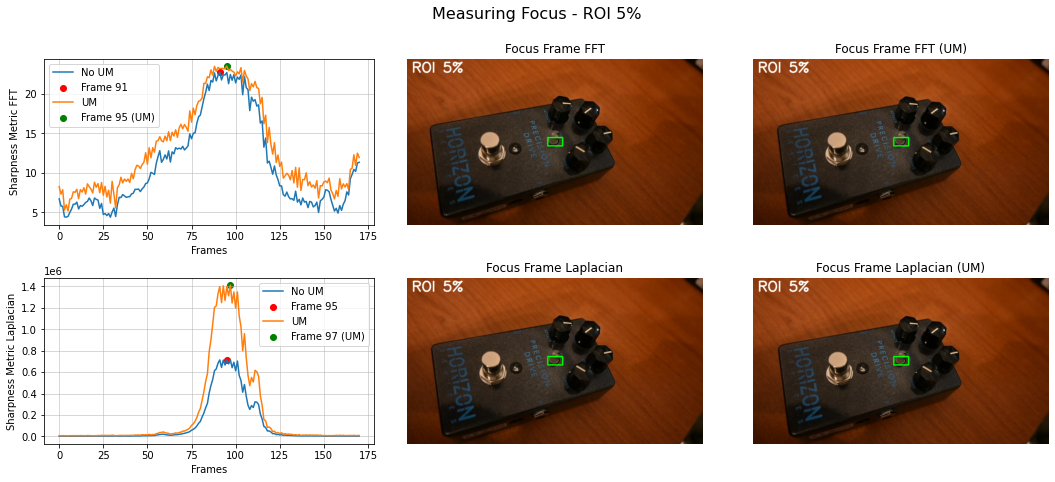

In [45]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))

# Plotting FFT metric
axs[0, 0].plot(sharpness_fft, label='No UM')
axs[0, 0].scatter(frame_i_fft, frame_shp_fft, color='red', label=f'Frame {frame_i_fft}')
axs[0, 0].plot(sharpness_fft_um, label='UM')
axs[0, 0].scatter(frame_i_fft_um, frame_shp_fft_um, color='green', label=f'Frame {frame_i_fft_um} (UM)')
axs[0, 0].set_xlabel('Frames')
axs[0, 0].set_ylabel('Sharpness Metric FFT')
axs[0, 0].legend()
axs[0, 0].grid(linewidth=0.5)

focus_frame_fft_cp = Video.drawRoi(focus_frame_fft.copy(), percentage, True)
axs[0, 1].imshow(focus_frame_fft_cp[..., ::-1])
axs[0, 1].set_title('Focus Frame FFT')
axs[0, 1].axis('off')

focus_frame_fft_um_cp = Video.drawRoi(focus_frame_fft_um.copy(), percentage, True)
axs[0, 2].imshow(focus_frame_fft_um_cp[..., ::-1])
axs[0, 2].set_title('Focus Frame FFT (UM)')
axs[0, 2].axis('off')

# Plotting Laplacian metric
axs[1, 0].plot(sharpness_lap, label='No UM')
axs[1, 0].scatter(frame_i_lap, frame_shp_lap, color='red', label=f'Frame {frame_i_lap}')
axs[1, 0].plot(sharpness_lap_um, label='UM')
axs[1, 0].scatter(frame_i_lap_um, frame_shp_lap_um, color='green', label=f'Frame {frame_i_lap_um} (UM)')
axs[1, 0].set_xlabel('Frames')
axs[1, 0].set_ylabel('Sharpness Metric Laplacian')
axs[1, 0].legend()
axs[1, 0].grid(linewidth=0.5)

focus_frame_lap_cp = Video.drawRoi(focus_frame_lap.copy(), percentage, True)
axs[1, 1].imshow(focus_frame_lap_cp[..., ::-1])
axs[1, 1].set_title('Focus Frame Laplacian')
axs[1, 1].axis('off')

focus_frame_lap_um_cp = Video.drawRoi(focus_frame_lap_um.copy(), percentage, True)
axs[1, 2].imshow(focus_frame_lap_um_cp[..., ::-1])
axs[1, 2].set_title('Focus Frame Laplacian (UM)')
axs[1, 2].axis('off')

plt.suptitle(f'Measuring Focus - ROI {percentage*100:.2g}%', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'focus_roi_{percentage*100:.2g}%.png', facecolor='white')
plt.show()

ROI = 10%

In [46]:
percentage = 0.1
my_video = Video("focus_video.mov")

# Metric: FFT. No unsharp mask
sharpness_fft = my_video.computeSharpnessMetric(percentage=percentage)
frame_i_fft, frame_shp_fft, focus_frame_fft = my_video.getFocusFrameByROI(percentage=percentage)
in_focus_fft = [s >= frame_shp_fft*0.9 for s in sharpness_fft]
frames_fft = my_video.drawFramesWithRoi(percentage=percentage, in_focus=in_focus_fft)
file_name = f'focus_fft_roi_{percentage*100:.2g}%.mp4'
my_video.create_video_from_frames(frames_fft, file_name)

# Metric: Laplacian. No unsharp mask
sharpness_lap = my_video.computeLaplacianSharpnessMetric(percentage=percentage)
frame_i_lap, frame_shp_lap, focus_frame_lap = my_video.getFocusFrameByROI(percentage=percentage, method="laplacian")
in_focus_lap = [s >= frame_shp_lap*0.9 for s in sharpness_lap]
frames_lap = my_video.drawFramesWithRoi(percentage=percentage, in_focus=in_focus_lap)
file_name = f'focus_lap_roi_{percentage*100:.2g}%.mp4'
my_video.create_video_from_frames(frames_lap, file_name)

# Metric: FFT. Unsharp mask
sharpness_fft_um = my_video.computeSharpnessMetric(percentage=percentage, unsharp_mask=True)
frame_i_fft_um, frame_shp_fft_um, focus_frame_fft_um = my_video.getFocusFrameByROI(percentage=percentage, unsharp_mask=True)
in_focus_fft_um = [s >= frame_shp_fft_um*0.9 for s in sharpness_fft_um]
frames_fft_um = my_video.drawFramesWithRoi(percentage=percentage, in_focus=in_focus_fft_um)
file_name = f'focus_fft_um_roi_{percentage*100:.2g}%.mp4'
my_video.create_video_from_frames(frames_fft_um, file_name)

# Metric: Laplacian. Unsharp mask
sharpness_lap_um = my_video.computeLaplacianSharpnessMetric(percentage=percentage, unsharp_mask=True)
frame_i_lap_um, frame_shp_lap_um, focus_frame_lap_um = my_video.getFocusFrameByROI(percentage=percentage, method="laplacian", unsharp_mask=True)
in_focus_lap_um = [s >= frame_shp_lap_um*0.9 for s in sharpness_lap_um]
frames_lap_um = my_video.drawFramesWithRoi(percentage=percentage, in_focus=in_focus_lap_um)
file_name = f'focus_lap_um_roi_{percentage*100:.2g}%.mp4'
my_video.create_video_from_frames(frames_lap_um, file_name)

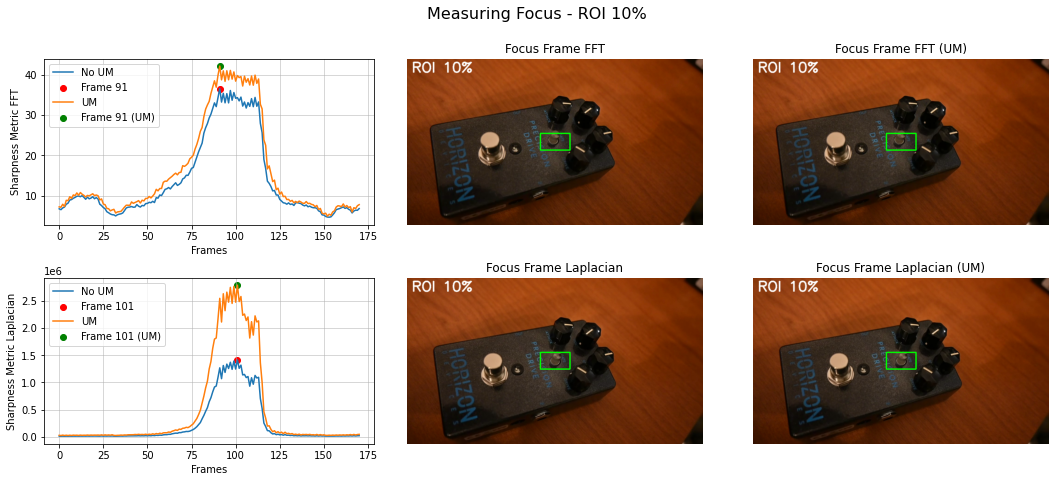

In [47]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))

# Plotting FFT metric
axs[0, 0].plot(sharpness_fft, label='No UM')
axs[0, 0].scatter(frame_i_fft, frame_shp_fft, color='red', label=f'Frame {frame_i_fft}')
axs[0, 0].plot(sharpness_fft_um, label='UM')
axs[0, 0].scatter(frame_i_fft_um, frame_shp_fft_um, color='green', label=f'Frame {frame_i_fft_um} (UM)')
axs[0, 0].set_xlabel('Frames')
axs[0, 0].set_ylabel('Sharpness Metric FFT')
axs[0, 0].legend()
axs[0, 0].grid(linewidth=0.5)

focus_frame_fft_cp = Video.drawRoi(focus_frame_fft.copy(), percentage, True)
axs[0, 1].imshow(focus_frame_fft_cp[..., ::-1])
axs[0, 1].set_title('Focus Frame FFT')
axs[0, 1].axis('off')

focus_frame_fft_um_cp = Video.drawRoi(focus_frame_fft_um.copy(), percentage, True)
axs[0, 2].imshow(focus_frame_fft_um_cp[..., ::-1])
axs[0, 2].set_title('Focus Frame FFT (UM)')
axs[0, 2].axis('off')

# Plotting Laplacian metric
axs[1, 0].plot(sharpness_lap, label='No UM')
axs[1, 0].scatter(frame_i_lap, frame_shp_lap, color='red', label=f'Frame {frame_i_lap}')
axs[1, 0].plot(sharpness_lap_um, label='UM')
axs[1, 0].scatter(frame_i_lap_um, frame_shp_lap_um, color='green', label=f'Frame {frame_i_lap_um} (UM)')
axs[1, 0].set_xlabel('Frames')
axs[1, 0].set_ylabel('Sharpness Metric Laplacian')
axs[1, 0].legend()
axs[1, 0].grid(linewidth=0.5)

focus_frame_lap_cp = Video.drawRoi(focus_frame_lap.copy(), percentage, True)
axs[1, 1].imshow(focus_frame_lap_cp[..., ::-1])
axs[1, 1].set_title('Focus Frame Laplacian')
axs[1, 1].axis('off')

focus_frame_lap_um_cp = Video.drawRoi(focus_frame_lap_um.copy(), percentage, True)
axs[1, 2].imshow(focus_frame_lap_um_cp[..., ::-1])
axs[1, 2].set_title('Focus Frame Laplacian (UM)')
axs[1, 2].axis('off')

plt.suptitle(f'Measuring Focus - ROI {percentage*100:.2g}%', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'focus_roi_{percentage*100:.2g}%.png', facecolor='white')
plt.show()

### Detección sobre una matriz

Matriz de 3x3

In [50]:
N, M = 3, 3
my_video = Video("focus_video.mov")

# Metric: FFT. No unsharp mask
sharpness_fft = my_video.computeSharpnessMetricByMOR(N=N, M=M)
frame_i_fft, frame_shp_fft, focus_frame_fft = my_video.getFocusFrameByMOR(N=N, M=M)
in_focus_fft = [s >= frame_shp_fft*0.9 for s in sharpness_fft]
frames_fft = my_video.getFrames(range(my_video.n_frames))
frames_fft = [Video.drawMatrixOfRegions(frame, N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames_fft, in_focus_fft)]
file_name = f'focus_fft_mor_{N}x{M}.mp4'
my_video.create_video_from_frames(frames_fft, file_name)

# Metric: Laplacian. No unsharp mask
sharpness_lap = my_video.computeSharpnessMetricByMOR(N=N, M=M, method="laplacian")
frame_i_lap, frame_shp_lap, focus_frame_lap = my_video.getFocusFrameByMOR(N=N, M=M, method="laplacian")
in_focus_lap = [s >= frame_shp_lap*0.9 for s in sharpness_lap]
frames_lap = my_video.getFrames(range(my_video.n_frames))
frames_lap = [Video.drawMatrixOfRegions(frame, N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames_lap, in_focus_lap)]
file_name = f'focus_lap_mor_{N}x{M}.mp4'
my_video.create_video_from_frames(frames_lap, file_name)

# Metric: FFT. Unsharp mask
sharpness_fft_um = my_video.computeSharpnessMetricByMOR(N=N, M=M, unsharp_mask=True)
frame_i_fft_um, frame_shp_fft_um, focus_frame_fft_um = my_video.getFocusFrameByMOR(N=N, M=M, unsharp_mask=True)
in_focus_fft_um = [s >= frame_shp_fft_um*0.9 for s in sharpness_fft_um]
frames_fft_um = my_video.getFrames(range(my_video.n_frames))
frames_fft_um = [Video.drawMatrixOfRegions(frame, N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames_fft_um, in_focus_fft_um)]
file_name = f'focus_fft_um_mor_{N}x{M}.mp4'
my_video.create_video_from_frames(frames_fft_um, file_name)

# Metric: Laplacian. Unsharp mask
sharpness_lap_um = my_video.computeSharpnessMetricByMOR(N=N, M=M, method='laplacian', unsharp_mask=True)
frame_i_lap_um, frame_shp_lap_um, focus_frame_lap_um = my_video.getFocusFrameByMOR(N=N, M=M, method="laplacian", unsharp_mask=True)
in_focus_lap_um = [s >= frame_shp_lap_um*0.9 for s in sharpness_lap_um]
frames_lap_um = my_video.getFrames(range(my_video.n_frames))
frames_lap_um = [Video.drawMatrixOfRegions(frame, N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames_lap_um, in_focus_lap_um)]
file_name = f'focus_lap_um_mor_{N}x{M}.mp4'
my_video.create_video_from_frames(frames_lap_um, file_name)

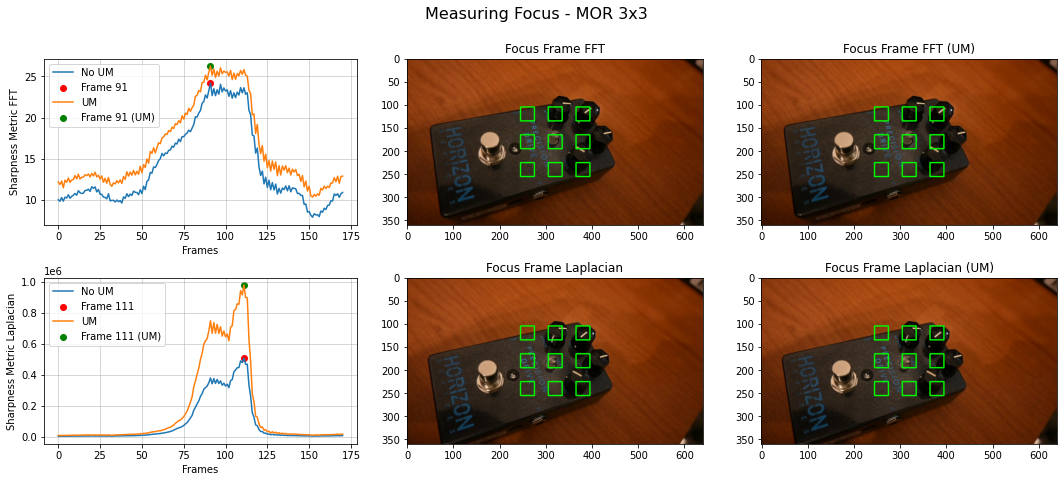

In [51]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))

# Plotting FFT metric
axs[0, 0].plot(sharpness_fft, label='No UM')
axs[0, 0].scatter(frame_i_fft, frame_shp_fft, color='red', label=f'Frame {frame_i_fft}')
axs[0, 0].plot(sharpness_fft_um, label='UM')
axs[0, 0].scatter(frame_i_fft_um, frame_shp_fft_um, color='green', label=f'Frame {frame_i_fft_um} (UM)')
axs[0, 0].set_xlabel('Frames')
axs[0, 0].set_ylabel('Sharpness Metric FFT')
axs[0, 0].legend()
axs[0, 0].grid(linewidth=0.5)

focus_frame_fft_cp = Video.drawMatrixOfRegions(focus_frame_fft.copy(), N=N, M=M, in_focus=True)
axs[0, 1].imshow(focus_frame_fft_cp[..., ::-1])
axs[0, 1].set_title('Focus Frame FFT')

focus_frame_fft_um_cp = Video.drawMatrixOfRegions(focus_frame_fft_um.copy(), N=N, M=M, in_focus=True)
axs[0, 2].imshow(focus_frame_fft_um_cp[..., ::-1])
axs[0, 2].set_title('Focus Frame FFT (UM)')

# Plotting Laplacian metric
axs[1, 0].plot(sharpness_lap, label='No UM')
axs[1, 0].scatter(frame_i_lap, frame_shp_lap, color='red', label=f'Frame {frame_i_lap}')
axs[1, 0].plot(sharpness_lap_um, label='UM')
axs[1, 0].scatter(frame_i_lap_um, frame_shp_lap_um, color='green', label=f'Frame {frame_i_lap_um} (UM)')
axs[1, 0].set_xlabel('Frames')
axs[1, 0].set_ylabel('Sharpness Metric Laplacian')
axs[1, 0].legend()
axs[1, 0].grid(linewidth=0.5)

focus_frame_lap_cp = Video.drawMatrixOfRegions(focus_frame_lap.copy(), N=N, M=M, in_focus=True)
axs[1, 1].imshow(focus_frame_lap_cp[..., ::-1])
axs[1, 1].set_title('Focus Frame Laplacian')

focus_frame_lap_um_cp = Video.drawMatrixOfRegions(focus_frame_lap_um.copy(), N=N, M=M, in_focus=True)
axs[1, 2].imshow(focus_frame_lap_um_cp[..., ::-1])
axs[1, 2].set_title('Focus Frame Laplacian (UM)')

plt.suptitle(f'Measuring Focus - MOR {N}x{M}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'focus_mor_{N}x{M}.png', facecolor='white')
plt.show()

Matriz de 5x5

In [52]:
N, M = 5, 5
my_video = Video("focus_video.mov")

# Metric: FFT. No unsharp mask
sharpness_fft = my_video.computeSharpnessMetricByMOR(N=N, M=M)
frame_i_fft, frame_shp_fft, focus_frame_fft = my_video.getFocusFrameByMOR(N=N, M=M)
in_focus_fft = [s >= frame_shp_fft*0.9 for s in sharpness_fft]
frames_fft = my_video.getFrames(range(my_video.n_frames))
frames_fft = [Video.drawMatrixOfRegions(frame, N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames_fft, in_focus_fft)]
file_name = f'focus_fft_mor_{N}x{M}.mp4'
my_video.create_video_from_frames(frames_fft, file_name)

# Metric: Laplacian. No unsharp mask
sharpness_lap = my_video.computeSharpnessMetricByMOR(N=N, M=M, method="laplacian")
frame_i_lap, frame_shp_lap, focus_frame_lap = my_video.getFocusFrameByMOR(N=N, M=M, method="laplacian")
in_focus_lap = [s >= frame_shp_lap*0.9 for s in sharpness_lap]
frames_lap = my_video.getFrames(range(my_video.n_frames))
frames_lap = [Video.drawMatrixOfRegions(frame, N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames_lap, in_focus_lap)]
file_name = f'focus_lap_mor_{N}x{M}.mp4'
my_video.create_video_from_frames(frames_lap, file_name)

# Metric: FFT. Unsharp mask
sharpness_fft_um = my_video.computeSharpnessMetricByMOR(N=N, M=M, unsharp_mask=True)
frame_i_fft_um, frame_shp_fft_um, focus_frame_fft_um = my_video.getFocusFrameByMOR(N=N, M=M, unsharp_mask=True)
in_focus_fft_um = [s >= frame_shp_fft_um*0.9 for s in sharpness_fft_um]
frames_fft_um = my_video.getFrames(range(my_video.n_frames))
frames_fft_um = [Video.drawMatrixOfRegions(frame, N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames_fft_um, in_focus_fft_um)]
file_name = f'focus_fft_um_mor_{N}x{M}.mp4'
my_video.create_video_from_frames(frames_fft_um, file_name)

# Metric: Laplacian. Unsharp mask
sharpness_lap_um = my_video.computeSharpnessMetricByMOR(N=N, M=M, method='laplacian', unsharp_mask=True)
frame_i_lap_um, frame_shp_lap_um, focus_frame_lap_um = my_video.getFocusFrameByMOR(N=N, M=M, method="laplacian", unsharp_mask=True)
in_focus_lap_um = [s >= frame_shp_lap_um*0.9 for s in sharpness_lap_um]
frames_lap_um = my_video.getFrames(range(my_video.n_frames))
frames_lap_um = [Video.drawMatrixOfRegions(frame, N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames_lap_um, in_focus_lap_um)]
file_name = f'focus_lap_um_mor_{N}x{M}.mp4'
my_video.create_video_from_frames(frames_lap_um, file_name)

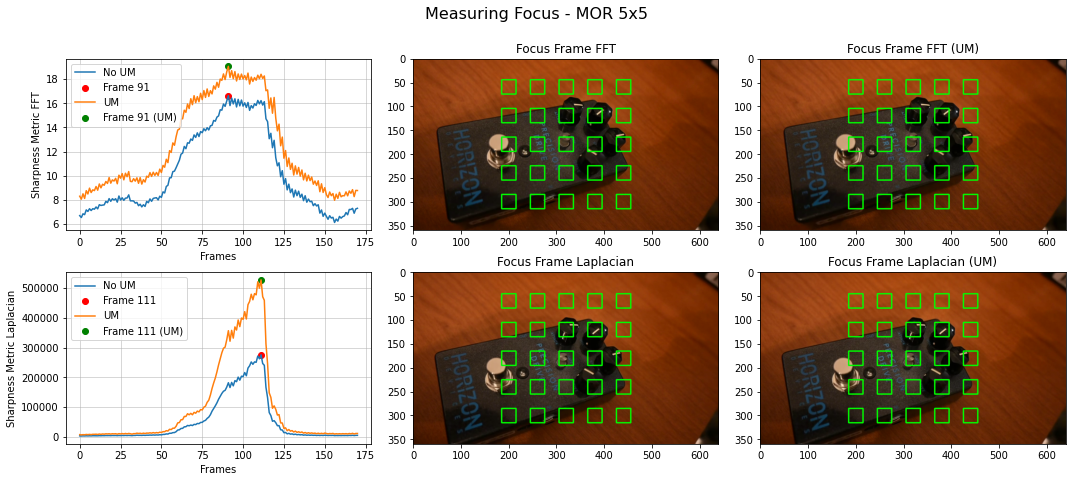

In [53]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))

# Plotting FFT metric
axs[0, 0].plot(sharpness_fft, label='No UM')
axs[0, 0].scatter(frame_i_fft, frame_shp_fft, color='red', label=f'Frame {frame_i_fft}')
axs[0, 0].plot(sharpness_fft_um, label='UM')
axs[0, 0].scatter(frame_i_fft_um, frame_shp_fft_um, color='green', label=f'Frame {frame_i_fft_um} (UM)')
axs[0, 0].set_xlabel('Frames')
axs[0, 0].set_ylabel('Sharpness Metric FFT')
axs[0, 0].legend()
axs[0, 0].grid(linewidth=0.5)

focus_frame_fft_cp = Video.drawMatrixOfRegions(focus_frame_fft.copy(), N=N, M=M, in_focus=True)
axs[0, 1].imshow(focus_frame_fft_cp[..., ::-1])
axs[0, 1].set_title('Focus Frame FFT')

focus_frame_fft_um_cp = Video.drawMatrixOfRegions(focus_frame_fft_um.copy(), N=N, M=M, in_focus=True)
axs[0, 2].imshow(focus_frame_fft_um_cp[..., ::-1])
axs[0, 2].set_title('Focus Frame FFT (UM)')

# Plotting Laplacian metric
axs[1, 0].plot(sharpness_lap, label='No UM')
axs[1, 0].scatter(frame_i_lap, frame_shp_lap, color='red', label=f'Frame {frame_i_lap}')
axs[1, 0].plot(sharpness_lap_um, label='UM')
axs[1, 0].scatter(frame_i_lap_um, frame_shp_lap_um, color='green', label=f'Frame {frame_i_lap_um} (UM)')
axs[1, 0].set_xlabel('Frames')
axs[1, 0].set_ylabel('Sharpness Metric Laplacian')
axs[1, 0].legend()
axs[1, 0].grid(linewidth=0.5)

focus_frame_lap_cp = Video.drawMatrixOfRegions(focus_frame_lap.copy(), N=N, M=M, in_focus=True)
axs[1, 1].imshow(focus_frame_lap_cp[..., ::-1])
axs[1, 1].set_title('Focus Frame Laplacian')

focus_frame_lap_um_cp = Video.drawMatrixOfRegions(focus_frame_lap_um.copy(), N=N, M=M, in_focus=True)
axs[1, 2].imshow(focus_frame_lap_um_cp[..., ::-1])
axs[1, 2].set_title('Focus Frame Laplacian (UM)')

plt.suptitle(f'Measuring Focus - MOR {N}x{M}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'focus_mor_{N}x{M}.png', facecolor='white')
plt.show()

Matriz de 2x6

In [54]:
N, M = 2, 6
my_video = Video("focus_video.mov")

# Metric: FFT. No unsharp mask
sharpness_fft = my_video.computeSharpnessMetricByMOR(N=N, M=M)
frame_i_fft, frame_shp_fft, focus_frame_fft = my_video.getFocusFrameByMOR(N=N, M=M)
in_focus_fft = [s >= frame_shp_fft*0.9 for s in sharpness_fft]
frames_fft = my_video.getFrames(range(my_video.n_frames))
frames_fft = [Video.drawMatrixOfRegions(frame, N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames_fft, in_focus_fft)]
file_name = f'focus_fft_mor_{N}x{M}.mp4'
my_video.create_video_from_frames(frames_fft, file_name)

# Metric: Laplacian. No unsharp mask
sharpness_lap = my_video.computeSharpnessMetricByMOR(N=N, M=M, method="laplacian")
frame_i_lap, frame_shp_lap, focus_frame_lap = my_video.getFocusFrameByMOR(N=N, M=M, method="laplacian")
in_focus_lap = [s >= frame_shp_lap*0.9 for s in sharpness_lap]
frames_lap = my_video.getFrames(range(my_video.n_frames))
frames_lap = [Video.drawMatrixOfRegions(frame, N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames_lap, in_focus_lap)]
file_name = f'focus_lap_mor_{N}x{M}.mp4'
my_video.create_video_from_frames(frames_lap, file_name)

# Metric: FFT. Unsharp mask
sharpness_fft_um = my_video.computeSharpnessMetricByMOR(N=N, M=M, unsharp_mask=True)
frame_i_fft_um, frame_shp_fft_um, focus_frame_fft_um = my_video.getFocusFrameByMOR(N=N, M=M, unsharp_mask=True)
in_focus_fft_um = [s >= frame_shp_fft_um*0.9 for s in sharpness_fft_um]
frames_fft_um = my_video.getFrames(range(my_video.n_frames))
frames_fft_um = [Video.drawMatrixOfRegions(frame, N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames_fft_um, in_focus_fft_um)]
file_name = f'focus_fft_um_mor_{N}x{M}.mp4'
my_video.create_video_from_frames(frames_fft_um, file_name)

# Metric: Laplacian. Unsharp mask
sharpness_lap_um = my_video.computeSharpnessMetricByMOR(N=N, M=M, method='laplacian', unsharp_mask=True)
frame_i_lap_um, frame_shp_lap_um, focus_frame_lap_um = my_video.getFocusFrameByMOR(N=N, M=M, method="laplacian", unsharp_mask=True)
in_focus_lap_um = [s >= frame_shp_lap_um*0.9 for s in sharpness_lap_um]
frames_lap_um = my_video.getFrames(range(my_video.n_frames))
frames_lap_um = [Video.drawMatrixOfRegions(frame, N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames_lap_um, in_focus_lap_um)]
file_name = f'focus_lap_um_mor_{N}x{M}.mp4'
my_video.create_video_from_frames(frames_lap_um, file_name)

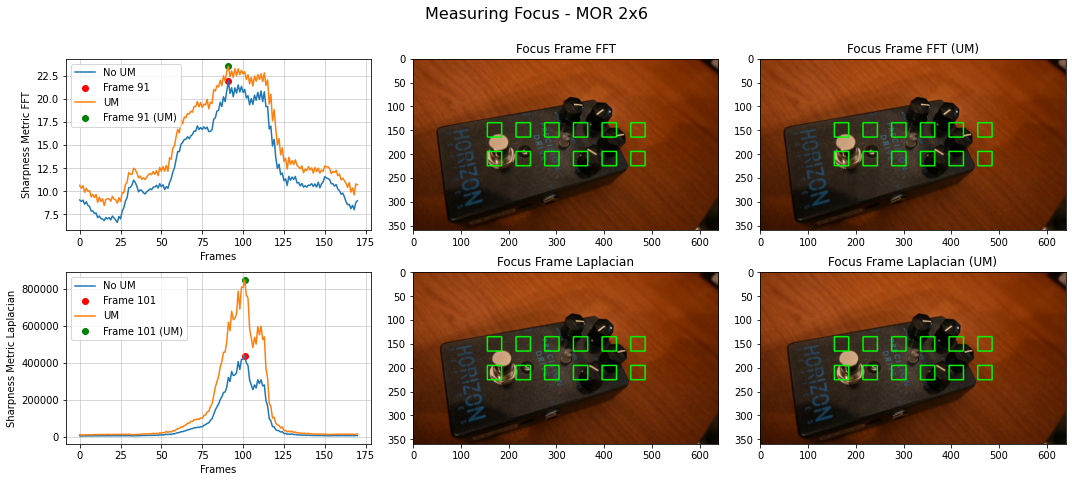

In [55]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))

# Plotting FFT metric
axs[0, 0].plot(sharpness_fft, label='No UM')
axs[0, 0].scatter(frame_i_fft, frame_shp_fft, color='red', label=f'Frame {frame_i_fft}')
axs[0, 0].plot(sharpness_fft_um, label='UM')
axs[0, 0].scatter(frame_i_fft_um, frame_shp_fft_um, color='green', label=f'Frame {frame_i_fft_um} (UM)')
axs[0, 0].set_xlabel('Frames')
axs[0, 0].set_ylabel('Sharpness Metric FFT')
axs[0, 0].legend()
axs[0, 0].grid(linewidth=0.5)

focus_frame_fft_cp = Video.drawMatrixOfRegions(focus_frame_fft.copy(), N=N, M=M, in_focus=True)
axs[0, 1].imshow(focus_frame_fft_cp[..., ::-1])
axs[0, 1].set_title('Focus Frame FFT')

focus_frame_fft_um_cp = Video.drawMatrixOfRegions(focus_frame_fft_um.copy(), N=N, M=M, in_focus=True)
axs[0, 2].imshow(focus_frame_fft_um_cp[..., ::-1])
axs[0, 2].set_title('Focus Frame FFT (UM)')

# Plotting Laplacian metric
axs[1, 0].plot(sharpness_lap, label='No UM')
axs[1, 0].scatter(frame_i_lap, frame_shp_lap, color='red', label=f'Frame {frame_i_lap}')
axs[1, 0].plot(sharpness_lap_um, label='UM')
axs[1, 0].scatter(frame_i_lap_um, frame_shp_lap_um, color='green', label=f'Frame {frame_i_lap_um} (UM)')
axs[1, 0].set_xlabel('Frames')
axs[1, 0].set_ylabel('Sharpness Metric Laplacian')
axs[1, 0].legend()
axs[1, 0].grid(linewidth=0.5)

focus_frame_lap_cp = Video.drawMatrixOfRegions(focus_frame_lap.copy(), N=N, M=M, in_focus=True)
axs[1, 1].imshow(focus_frame_lap_cp[..., ::-1])
axs[1, 1].set_title('Focus Frame Laplacian')

focus_frame_lap_um_cp = Video.drawMatrixOfRegions(focus_frame_lap_um.copy(), N=N, M=M, in_focus=True)
axs[1, 2].imshow(focus_frame_lap_um_cp[..., ::-1])
axs[1, 2].set_title('Focus Frame Laplacian (UM)')

plt.suptitle(f'Measuring Focus - MOR {N}x{M}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'focus_mor_{N}x{M}.png', facecolor='white')
plt.show()